In [19]:
from operator import add
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.stats import LombScargle
from gatspy.periodic import LombScargleFast
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import numpy as np
from sqlite3 import *
import random
from random import shuffle

In [20]:
#conn = connect('minion_1016_sqlite.db')
conn = connect('astro_lsst_01_1004_sqlite.db')

In [21]:
# LSST zero points  u,g,r,i,z,y
zeroPoints = [0,26.5,28.3,28.13,27.79,27.4,26.58]
FWHMeff = [0.8,0.92,0.87,0.83,0.80,0.78,0.76] # arcmins?
pixelScale = 0.2
readOut = 12.7
sigSys = 0.005

In [22]:
def magUncertainy(Filter, objectmag, exposuretime,background, FWHM): # b is background counts per pixel   
    countsPS = 10**((Filter-objectmag)/2.5)
    counts = countsPS * exposuretime
    uncertainty = 1/(counts/((counts/2.3)+(((background/2.3)+(12.7**2))*2.266*((FWHM/0.2)**2)))**0.5) # gain assumed to be 1
    return uncertainty

In [23]:
magUncertainy(zeroPoints[0],20,30,100,FWHMeff[0])   

287210299.76535374

In [24]:
def findObservations(fields): #fields are array in the format [(630,), (631,)] etc
    global obs, allobs, uobs, gobs, robs, iobs, zobs, yobs
    x2 = fields # field containing gx 339-4
    L = [0]*len(x2)
    z = 0
    c = conn.cursor()
    #t = [('357',),('356',)]
    for z in range(0,len(x2)):
        i = x2[z]    
        #c.execute('SELECT expMJD, Field_fieldID, filter FROM ObsHistory WHERE Field_fieldID = ?',i)
        #k = c.fetchall()
        c.execute('SELECT expMJD FROM ObsHistory WHERE Field_fieldID = ?', i)
        allobs = c.fetchall()
        c.execute('SELECT expMJD FROM ObsHistory WHERE filter = "u" AND Field_fieldID = ?', i)
        uobs= c.fetchall()
        c.execute('SELECT expMJD FROM ObsHistory WHERE filter = "g" AND Field_fieldID = ?', i)
        gobs = c.fetchall()
        c.execute('SELECT expMJD FROM ObsHistory WHERE filter = "r" AND Field_fieldID = ?', i)
        robs = c.fetchall()
        c.execute('SELECT expMJD FROM ObsHistory WHERE filter = "i" AND Field_fieldID = ?', i)
        iobs = c.fetchall()
        c.execute('SELECT expMJD FROM ObsHistory WHERE filter = "z" AND Field_fieldID = ?', i)
        zobs = c.fetchall()
        c.execute('SELECT expMJD FROM ObsHistory WHERE filter = "y" AND Field_fieldID = ?', i)
        yobs = c.fetchall()
        
    obs = [allobs, uobs, gobs, robs, iobs, zobs, yobs]
    for x in range(0, len(obs)):
        for y in range(0, len(obs[x])):
            obs[x][y] = np.mean(obs[x][y])
        

In [25]:
def addsecondExposure():
    #global obs, allobs2, uobs2, gobs2, robs2, iobs2, zobs2, yobs2
    #obs = [allobs, uobs, gobs, robs, iobs, zobs, yobs]
    for x in range(0, len(obs)):
        for y in range(0, len(obs[x])):
            obs[x][y] = np.mean(obs[x][y])
    allobs2, uobs2, gobs2, robs2, iobs2, zobs2, yobs2 = [], [], [], [], [], [], []
    
    obs2 = [allobs2, uobs2, gobs2, robs2, iobs2, zobs2, yobs2]
    for x in range(0, len(obs)):
        obs2[x] = [t + (17./(3600*24)) for t in obs[x]]
    for x in range(0, len(obs)):
        obs[x].extend(obs2[x])
    for x in range(0, len(obs)):
        obs[x] = sorted(obs[x])
    # creates observation 17 seconds after first

In [110]:
def averageFlux(observations, Frequency, exptime):
    b = [0]*len(observations)
    for seconds in range(0, exptime):
        a = [np.sin((2*np.pi*(Frequency*0.01))*(x-observations[0]+(seconds*(3600*24)))) for x in observations] # optical modulation
        b = map(add, a, b)
    c = [z/exptime for z in b]
    return c

def Flux(observations,Frequency,exptime):
    a = [np.sin((2*np.pi*(Frequency*0.01)*x)) for x in observations]
    return a

In [85]:
def flaring(B, length, frequency=0, amplitude=1):   
    global flareMag, minutes
    np.linspace(0,np.log(8),length)
    fouriers = np.linspace(1,3000,length)
    logF = [np.log(x) for x in fouriers]
    real = [random.gauss(0,1)*((1/x)**(B/2)) for x in fouriers]
    #imaginary = [random.gauss(0,1)*((1/x)**(B/2)) for x in fouriers]
    IFT = np.fft.ifft(real)
    seconds = np.linspace(0,length, length)
    minutes = [x for x in seconds]
    #plt.show()
    minimum = (np.max(-IFT))
    positive = [x + minimum for x in IFT]
    normalised = [x/(np.mean(positive)) for x in positive]
    flareMag = [amplitude * x for x in normalised]
    return flareMag

In [28]:
def confidenceLevel(numsteps): # no sigma clipping?
    position = min(range(len(periods)), key=lambda i: abs(periods[i]-LSperiod))
    if position > numsteps:
        sigma = np.std(power[(position-numsteps):(position+numsteps)])
        mean = np.mean(power[(position-numsteps):(position+numsteps)])
    else:
        sigma = np.std(power[0:(position+numsteps)])
        mean = np.mean(power[0:(position+numsteps)])
    confidence = mean + (5*sigma)
    return confidence

In [150]:
def fullGraph(objectmag,frequency,modulationAmplitude=0.1,lower=0,higher=3500,ramp=1):
    global Zmag, dayZ
    minutesnotindays = np.linspace(0,(87660*ramp),(87661*ramp))#np.linspace(0,87660,87661) #np.linspace(0,5259600,5259601)
    Minutes = [(h/(24*ramp)) for h in minutesnotindays] # 4 24 24*60
    Z = []
    Z = Flux(Minutes, frequency, 30)  # amplitde calculation for observations, anf frequency range
    Z = [modulationAmplitude * t for t in Z]
    for G in range(0, len(Z)):
        flareMinute = int((Z[G]*24*60)%(1024))
        Z[G] = Z[G] + flareMag[flareMinute]

    Zamplitude = [t for t in Z]
    Zmag = [t + objectmag for t in Zamplitude]
    dayZ = [t for t in Minutes]

    plt.plot(dayZ,Zmag)
    plt.xlim(lower,higher)
    plt.xlabel('time')
    plt.ylabel('mag')
    plt.show()


In [181]:
def lombScargleAuto(frequencyRange,objectmag,lower=0,higher=3500,loopNo=1,numsteps=100000,modulationAmplitude=0.1,background=40,Nquist=200): # frequency range and object mag in list
    global actualperiod, measuredperiod, measuredpower, date, amplitude, frequency, periods, LSperiod, power, mag, error, SigLevel
    totperiod = [[],[],[],[],[],[]]
    totmperiod = [[],[],[],[],[],[]]
    totpower = [[],[],[],[],[],[]] # reset
    SigLevel = [[],[],[],[],[],[]]
    for frange in range(0, len(frequencyRange)):    
        allobsy, uobsy, gobsy, robsy, iobsy, zobsy, yobsy = [], [], [], [], [], [], [] #reset

        measuredpower = [] # reset
        
        y = [allobsy, uobsy, gobsy, robsy, iobsy, zobsy, yobsy] # for looping only
        for z in range(1, len(y)):
            y[z] = averageFlux(obs[z], frequencyRange[frange], 30)  # amplitde calculation for observations, anf frequency range
        for z in range(1, len(y)):
            y[z] = [modulationAmplitude * t for t in y[z]]            
        for z in range(1,len(y)):
            for G in range(0, len(y[z])):
                flareMinute = int((obs[z][G]*24*60)%(1024))
                y[z][G] = y[z][G] + flareMag[flareMinute]
                
        for z in range(1, len(y)):
            date = [x - obs[z][0] for x in obs[z]]
            date = date * u.day
            
            amplitude = [t+random.gauss(0,magUncertainy(zeroPoints[z],objectmag[z],30,background,FWHMeff[z])) for t in y[z]] # scale amplitude and add poisson noise
            amplitude = [t for t in y[z]]            
            mag = [t + objectmag[z] for t in amplitude]
            error = [sigSys+magUncertainy(zeroPoints[z],objectmag[z],30,background,FWHMeff[z])+0.2]*len(mag) 
                        
            #curve and observations
            plt.plot(dayZ,Zmag)
            plt.plot(date, mag, 'o')
            plt.xlim(lower,higher)
            plt.xlabel('time')
            plt.ylabel('mag')
            plt.show()
            
            model = LombScargleFast().fit(date, mag, error)
            periods, power = model.periodogram_auto(nyquist_factor=Nquist)
            
            model.optimizer.period_range=(0.01, 10)
            LSperiod = model.best_period
            
            fig, ax = plt.subplots()
            ax.plot(periods, power)
            #plt.plot([0,10],[fiveSig,fiveSig])
            ax.set(xlim=(0, 10), ylim=(0, 1.2),
                   xlabel='period (days)',
                   ylabel='Lomb-Scargle Power');
            plt.show()
            
            period = 100./(frequencyRange[frange])
            phase = [(day.value % (period*2))/(period*2) for day in date]
            idealphase = [(day % (period*2))/(period*2) for day in dayZ]
            
            plt.plot(idealphase,Zmag,'ko',)
            plt.plot(phase, mag, 'yo')
            
            plt.xlabel('Phase')
            plt.ylabel('Magnitude')
            plt.show()
            print('actualperiod', period, 'measured period', np.mean(LSperiod)),# 'power',np.mean(power[maxpos]))
            print('actualperiod', period, 'measured period', np.mean(LSperiod), periods.min(),power.max())# 'power',np.mean(power[maxpos]))
            print(frequencyRange[frange])
            
            totperiod[z-1].append(1/(frequencyRange[frange]*0.01))
            totmperiod[z-1].append(np.mean(LSperiod))
            totpower[z-1].append(power.max())
            
            measuredpower.append(power.max())
            maxpower = []
            counter = 0.
            for loop in range(0,loopNo):
                random.shuffle(date)
                model = LombScargleFast().fit(date, mag, error)
                periods, power = model.periodogram_auto(nyquist_factor=Nquist)
                maxpower.append(power.max())
                
            for X in range(0, len(maxpower)):
                if maxpower[X] > measuredpower[z-1]:
                    counter = counter + 1. 
            Significance = (1.-(counter/len(maxpower)))
            print('sig', Significance, 'counter', counter)
            SigLevel[z-1].append(Significance)


In [127]:
def lombScargle(frequencyRange,objectmag,loopNo=1,df=0.001,fmin=0.001,numsteps=100000,modulationAmplitude=0.1,background=40,Nquist=200): # frequency range and object mag in list
    global totperiod, totmperiod, totpower, date, amplitude, frequency, periods, LSperiod, power, mag, error, SigLevel
    totperiod = [[],[],[],[],[],[]]
    totmperiod = [[],[],[],[],[],[]]
    totpower = [[],[],[],[],[],[]] # reset
    SigLevel = [[],[],[],[],[],[]]
    freqs = fmin + df * np.arange(numsteps) # for manuel
    for frange in range(0, len(frequencyRange)):    
        allobsy, uobsy, gobsy, robsy, iobsy, zobsy, yobsy = [], [], [], [], [], [], [] #reset
        measuredpower = [] # reset
        y = [allobsy, uobsy, gobsy, robsy, iobsy, zobsy, yobsy] # for looping only
        for z in range(1, len(y)):
            y[z] = averageFlux(obs[z], frequencyRange[frange], 30)  # amplitde calculation for observations, anf frequency range
        for z in range(1, len(y)):
            y[z] = [modulationAmplitude * t for t in y[z]] # scaling
        
        for z in range(1,len(y)):    
            for G in range(0, len(y[z])):
                flareMinute = int((obs[z][G]*24*60)%(1024))
                y[z][G] = y[z][G] + flareMag[flareMinute] # add flares
                
        for z in range(1, len(y)):
            date = [x - obs[z][0] for x in obs[z]]
            date = date * u.day
            
            amplitude = [t+random.gauss(0,magUncertainy(zeroPoints[z],objectmag[z],30,background,FWHMeff[z])) for t in y[z]] # scale amplitude and add poisson noise

            mag = [t + objectmag[z] for t in amplitude] # add actual mag
            error = [sigSys+magUncertainy(zeroPoints[z],objectmag[z],30,background,FWHMeff[z])+0.2]*len(mag) 
                     
            model = LombScargleFast().fit(date, mag, error)
            power = model.score_frequency_grid(fmin, df, numsteps)  
            model.optimizer.period_range=(0.01, 10)
            LSperiod = model.best_period
            
            fig, ax = plt.subplots()
            ax.plot(1./freqs, power)
            ax.set(xlim=(0, 10), ylim=(0, 1.2),
                   xlabel='period (days)',
                   ylabel='Lomb-Scargle Power');
            plt.show()
            
            period = 100./(frequencyRange[frange])
#             phase = [(day.value % (period*2))/(period*2) for day in date]

#             plt.plot(phase, mag, 'o')
#             plt.xlabel('Phase')
#             plt.ylabel('Magnitude')
#             plt.show()

            print('actualperiod', period, 'measured period', np.mean(LSperiod), periods.min(),power.max())# 'power',np.mean(power[maxpos]))
            print(frequencyRange[frange], 'z', z)
                  
            totperiod[z-1].append(1/(frequencyRange[frange]*0.01))
            totmperiod[z-1].append(np.mean(LSperiod))
            totpower[z-1].append(power.max())
            
            measuredpower.append(power.max())
            maxpower = []           
            counter = 0.
            for loop in range(0,loopNo):
                random.shuffle(date)
                model = LombScargleFast().fit(date, mag, error)
                power = model.score_frequency_grid(fmin, df, numsteps)  
                maxpower.append(power.max())
                

            for X in range(0, len(maxpower)):
                if maxpower[X] > measuredpower[z-1]:
                    counter = counter + 1. 
            Significance = (1.-(counter/len(maxpower)))
            print('sig', Significance, 'counter', counter)
            SigLevel[z-1].append(Significance)
            

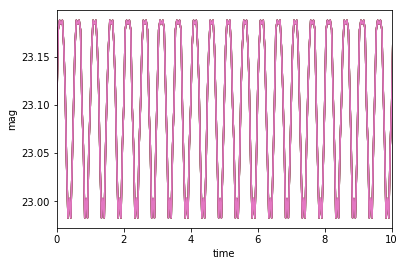

In [155]:
fullGraph([23]*7,5000,lower=0,higher=10,ramp=1)

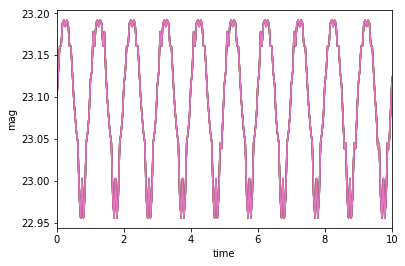

In [158]:
fullGraph([23]*7,100,lower=0,higher=10,ramp=1)

In [31]:
findObservations([(630,)])
#addsecondExposure()
averageFlux(obs[0], 1, 30)
flaring(-1, 10024, amplitude=0.1)

[(0.072170626964411663-0.015262032548835389j),
 (0.11128427040638203+0.0081727638594778617j),
 (0.074082108311126618-0.016899343336514296j),
 (0.098385708738377486+0.0048857298025818587j),
 (0.078628718095658218+0.048723752679851906j),
 (0.12291201082580838+0.025108166312314592j),
 (0.13437000264864857+0.019516926685948507j),
 (0.14129777287513537-0.055705446816282492j),
 (0.075853581510465021+0.0079442981968876319j),
 (0.077754192671839306+0.0026325200186600572j),
 (0.10306377386173962+0.0073727429144433603j),
 (0.13724330241129154+0.0072584449589065255j),
 (0.1255897988705845-0.039052081353407493j),
 (0.064840886769363018-0.022328382330586247j),
 (0.069353854309610857+0.016465401027073771j),
 (0.088546182101618354-0.0041380922170888819j),
 (0.074904831973986785-0.00021527861239207022j),
 (0.079300091182197108+0.027661150364533954j),
 (0.10245111408841419+0.044582918582050747j),
 (0.12703052367832221+0.036061331546966911j),
 (0.15144386045565805-0.026354534922102747j),
 (0.08570926247

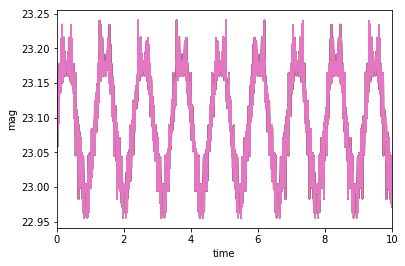

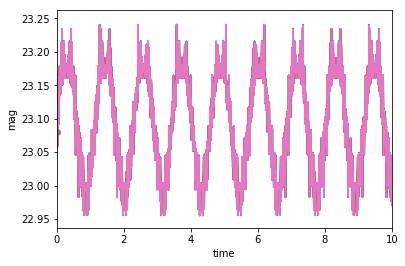

Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


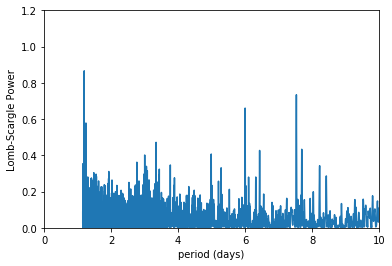

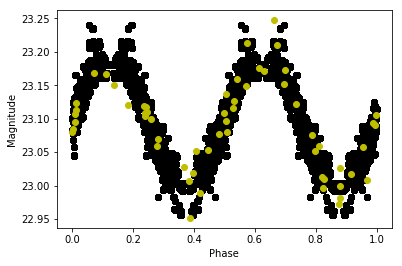

('actualperiod', 1.1494252873563218, 'measured period', 1.1494161345327407) ('actualperiod', 1.1494252873563218, 'measured period', 1.1494161345327407, 1.1506398937931026, (0.86626980973901213+0.15295194188546157j))
87
('sig', 1.0, 'counter', 0.0)


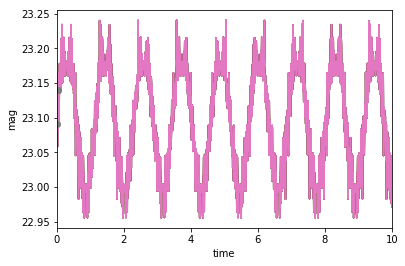

Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1708203 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


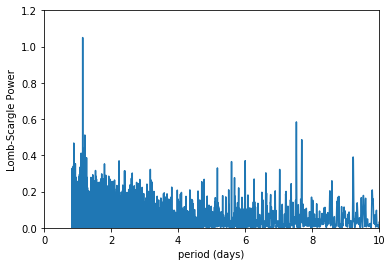

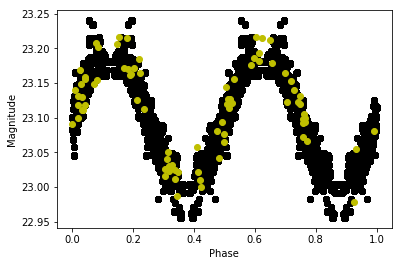

('actualperiod', 1.1494252873563218, 'measured period', 1.1494328148007231) ('actualperiod', 1.1494252873563218, 'measured period', 1.1494328148007231, 0.83410309926829251, (1.0497969559570481-0.026587342629485516j))
87
('sig', 1.0, 'counter', 0.0)


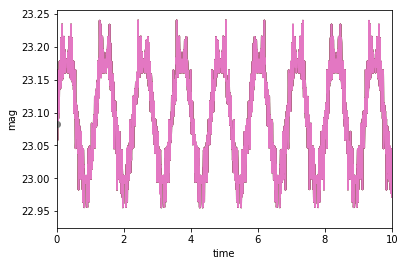

Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


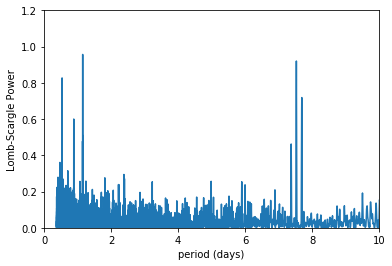

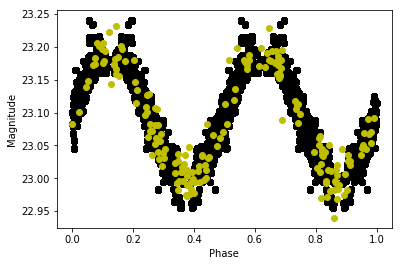

('actualperiod', 1.1494252873563218, 'measured period', 1.1494189146662213) ('actualperiod', 1.1494252873563218, 'measured period', 1.1494189146662213, 0.37163740518918909, (0.95666114105263034+0.051369502481263471j))
87
('sig', 1.0, 'counter', 0.0)


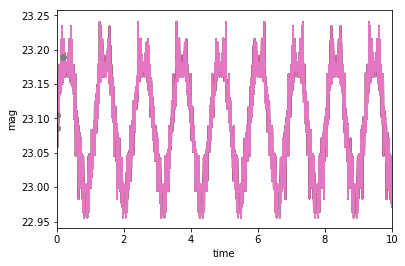

Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10
 - Computing periods at 1699746 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


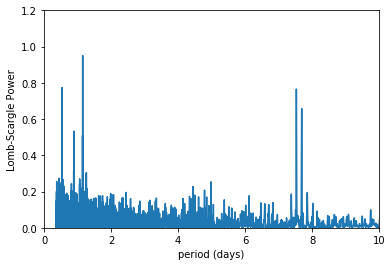

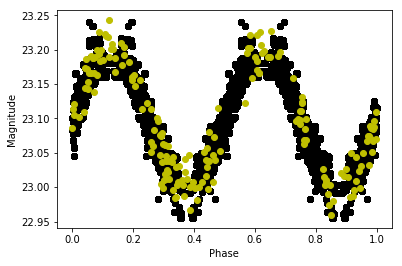

('actualperiod', 1.1494252873563218, 'measured period', 1.1494217333737093) ('actualperiod', 1.1494252873563218, 'measured period', 1.1494217333737093, 0.36590236645161317, (0.95085122680594969-0.021498114879820895j))
87
('sig', 1.0, 'counter', 0.0)


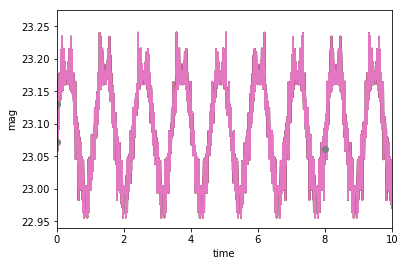

Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


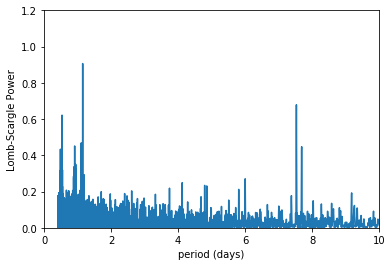

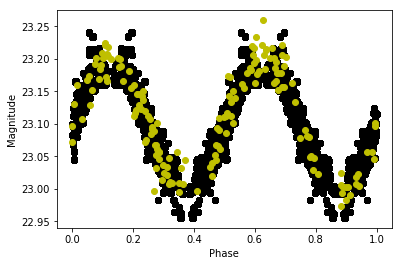

('actualperiod', 1.1494252873563218, 'measured period', 1.1494216787551041) ('actualperiod', 1.1494252873563218, 'measured period', 1.1494216787551041, 0.41372401652694546, (0.9063932489150448-0.035584900594070559j))
87
('sig', 1.0, 'counter', 0.0)


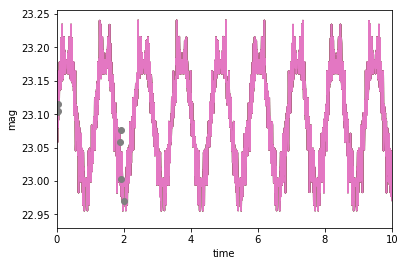

Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1710676 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


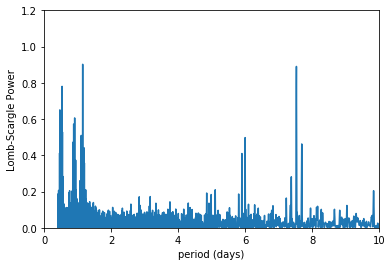

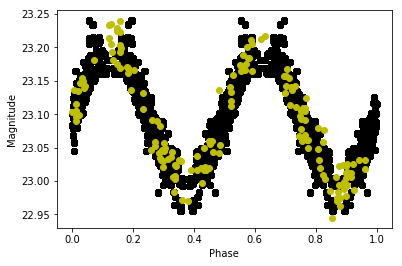

('actualperiod', 1.1494252873563218, 'measured period', 1.1494357385389513) ('actualperiod', 1.1494252873563218, 'measured period', 1.1494357385389513, 0.41015243664670648, (0.90235681093587439-0.013885362787669393j))
87
('sig', 1.0, 'counter', 0.0)


In [183]:
# actual frequency = frquency/100
fullGraph([23]*7,87,lower=0,higher=10,ramp=10)
lombScargleAuto([87],([23]*7),Nquist=100,lower=0,higher=10)
 # 40 background corresponing to R band at new moon, could be made more detailed?

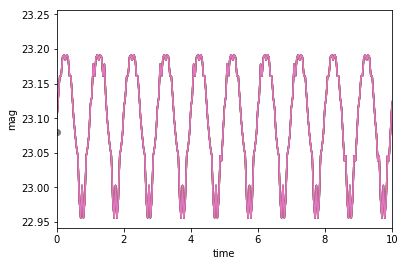

Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


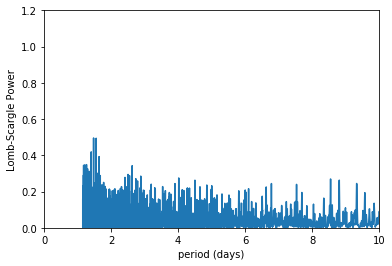

('actualperiod', 1.0, 'measured period', 1.0000108255178815, 1.1506398937931026, (0.86135004307954544-0.015302040756662369j))
100
('sig', 1.0, 'counter', 0.0)


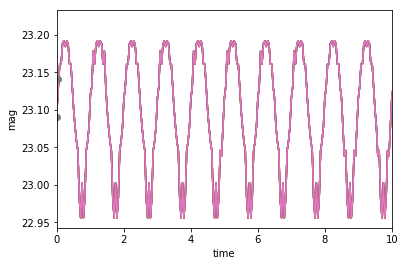

Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1708203 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


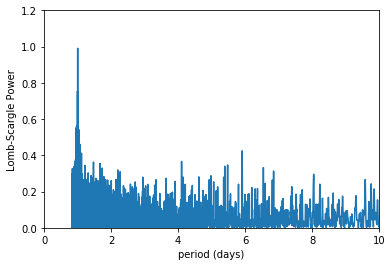

('actualperiod', 1.0, 'measured period', 0.99999954275421132, 0.83410309926829251, (1.0041754143007502+0.059992281115483027j))
100
('sig', 1.0, 'counter', 0.0)


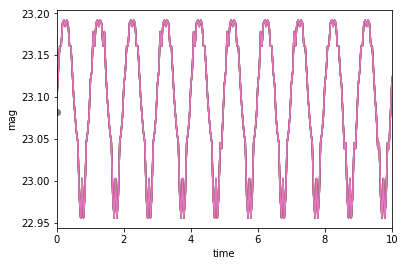

Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


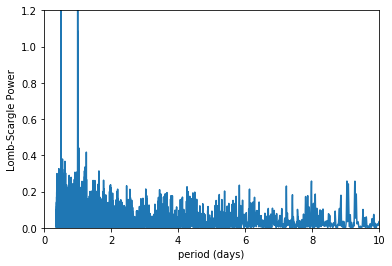

('actualperiod', 1.0, 'measured period', 0.99999342525336121, 0.37163740518918909, (1.6170809188374606-0.048838104966567347j))
100
('sig', 1.0, 'counter', 0.0)


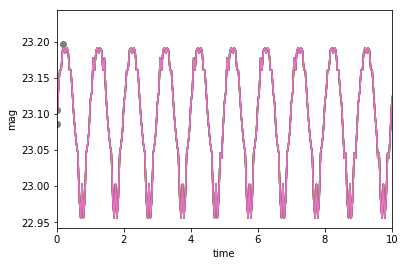

Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10
 - Computing periods at 1699746 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


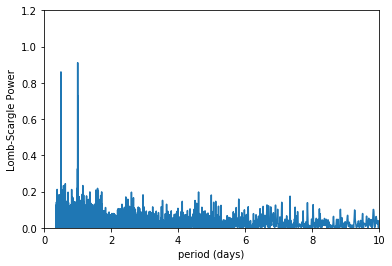

('actualperiod', 1.0, 'measured period', 0.9999996494747726, 0.36590236645161317, (0.91122966631318125+0.072071703631053072j))
100
('sig', 1.0, 'counter', 0.0)


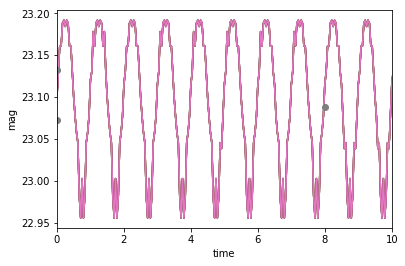

Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


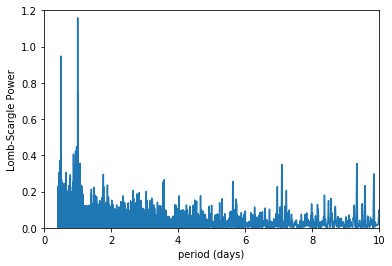

('actualperiod', 1.0, 'measured period', 1.0000034690722501, 0.41372401652694546, (1.1587513220814727-0.060010880442578289j))
100
('sig', 1.0, 'counter', 0.0)


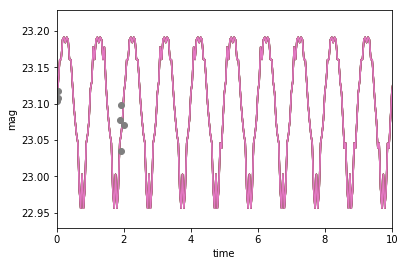

Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1710676 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


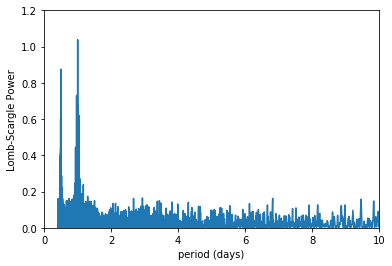

('actualperiod', 1.0, 'measured period', 1.000000455913562, 0.41015243664670648, (1.0379206502738971+0.021933103330893568j))
100
('sig', 1.0, 'counter', 0.0)


In [165]:
lombScargleAuto([100],([23]*7),Nquist=100,lower=0,higher=10)

Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


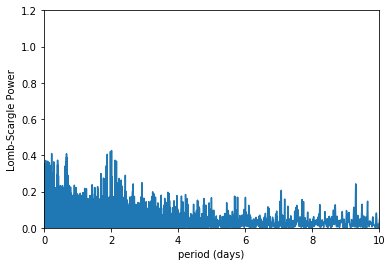

('actualperiod', 0.6666666666666666, 'measured period', 2.0111334664078786, 0.023012797875862051, (0.42648061259409009-0.013621843741346465j))
150


KeyboardInterrupt: 

In [74]:
lombScargleAuto([150],([23]*7),Nquist=5000,loopNo=10000)

Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


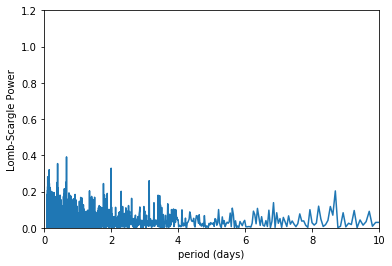

('actualperiod', 0.6666666666666666, 'measured period', 0.052030113756350846, 0.023012797875862051, (0.3912422541371855-0.037765333259005926j))
(150, 'z', 1)
('sig', 0.976, 'counter', 240.0)
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1708203 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


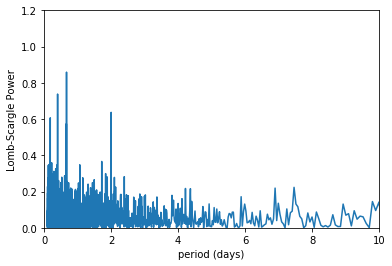

('actualperiod', 0.6666666666666666, 'measured period', 0.66666092110314212, 0.023012797875862051, (0.85902006952293553-0.065027394248840048j))
(150, 'z', 2)
('sig', 1.0, 'counter', 0.0)
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


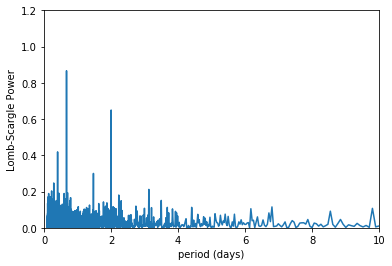

('actualperiod', 0.6666666666666666, 'measured period', 0.6666633565626654, 0.023012797875862051, (0.86662224802013821-0.037055276050263569j))
(150, 'z', 3)
('sig', 1.0, 'counter', 0.0)
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10
 - Computing periods at 1699746 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


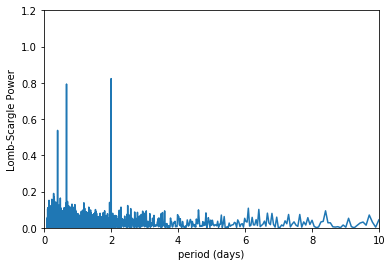

('actualperiod', 0.6666666666666666, 'measured period', 2.0000126989262168, 0.023012797875862051, (0.82328888940863643+0.027446433034215092j))
(150, 'z', 4)
('sig', 1.0, 'counter', 0.0)
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


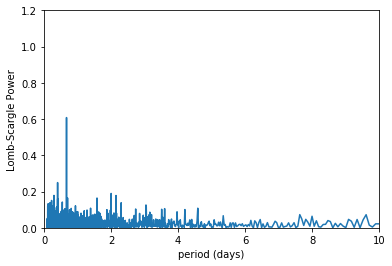

('actualperiod', 0.6666666666666666, 'measured period', 0.66666792144848586, 0.023012797875862051, (0.60836005445877717+0.026389972758706928j))
(150, 'z', 5)
('sig', 1.0, 'counter', 0.0)
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1710676 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


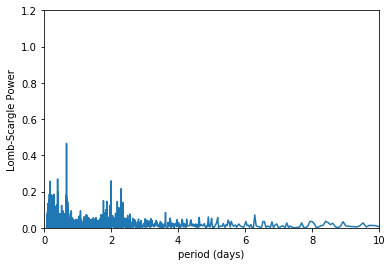

('actualperiod', 0.6666666666666666, 'measured period', 0.66666406918409271, 0.023012797875862051, (0.46559824687283008-0.0042475305156539443j))
(150, 'z', 6)
('sig', 1.0, 'counter', 0.0)


In [82]:
lombScargle([150],([23]*7),numsteps=10000,loopNo=10000)

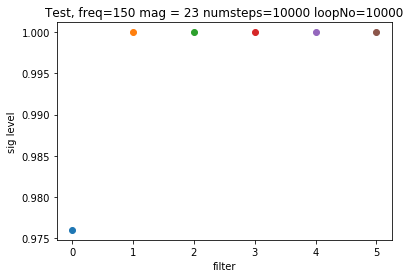

In [83]:
for d in range(0,len(SigLevel)):    
    plt.plot(d,SigLevel[d],'o')
plt.xlabel('filter')
plt.ylabel('sig level')
plt.title('Test, freq=150 mag = 23 numsteps=10000 loopNo=10000')
plt.show()

Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


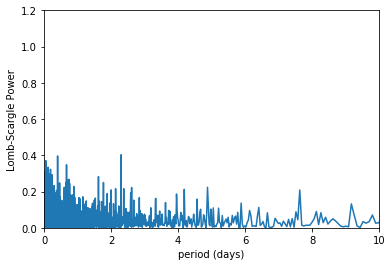

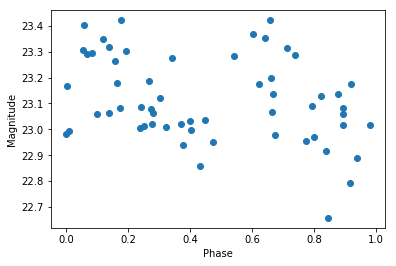

('actualperiod', 0.6666666666666666, 'measured period', 1.9890609159774093) 150
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1708203 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


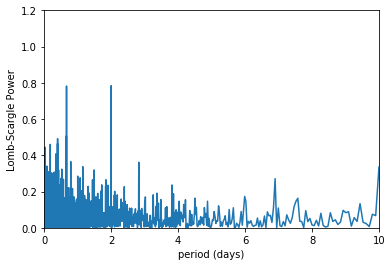

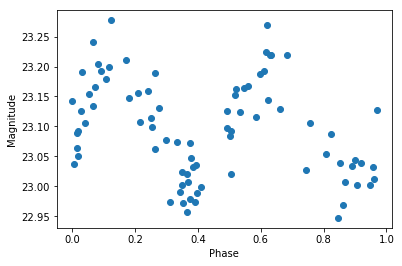

('actualperiod', 0.6666666666666666, 'measured period', 0.66667105806029403) 150
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


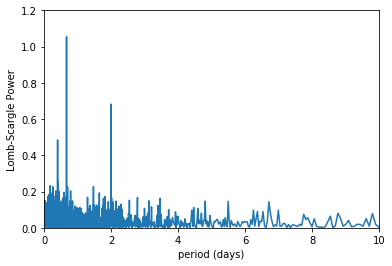

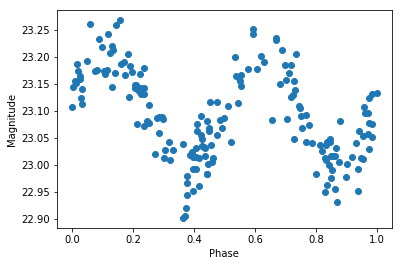

('actualperiod', 0.6666666666666666, 'measured period', 0.66667059666593531) 150
Finding optimal frequency:
 - Estimated peak width = 0.00185
 - Using 5 steps per peak; omega_step = 0.000369
 - User-specified period range:  0.01 to 10
 - Computing periods at 1699746 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


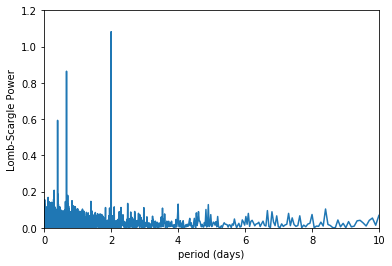

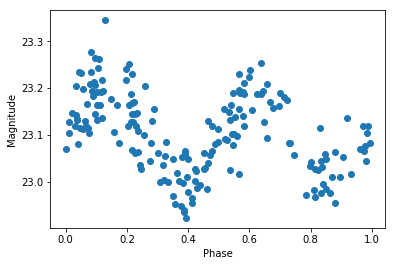

('actualperiod', 0.6666666666666666, 'measured period', 1.9999962422622317) 150
Finding optimal frequency:
 - Estimated peak width = 0.00182
 - Using 5 steps per peak; omega_step = 0.000364
 - User-specified period range:  0.01 to 10
 - Computing periods at 1725572 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


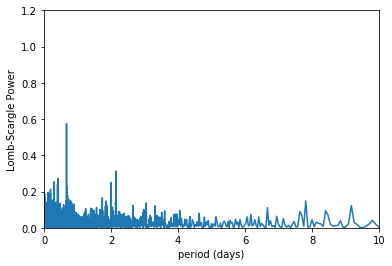

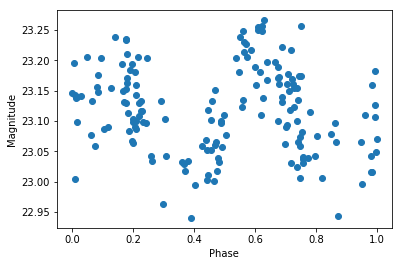

('actualperiod', 0.6666666666666666, 'measured period', 0.66667332494305631) 150
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1710676 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


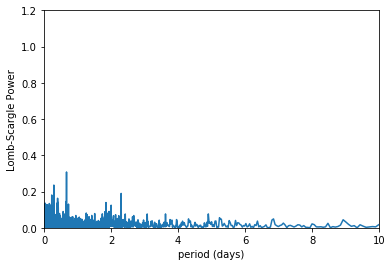

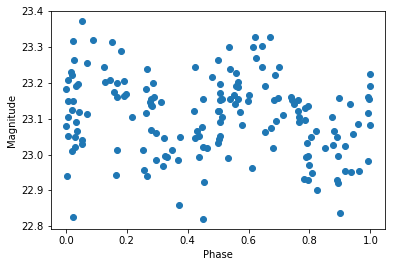

('actualperiod', 0.6666666666666666, 'measured period', 0.66665784016724228) 150


In [21]:
lombScargle([150],([23]*7),numsteps=100000)

In [30]:
lombScargle([150],([23]*7),numsteps=500000)

Finding optimal frequency:
 - Estimated peak width = 0.00188
 - Using 5 steps per peak; omega_step = 0.000377
 - User-specified period range:  0.01 to 10
 - Computing periods at 1666761 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
('actualperiod', 0.6666666666666666, 'measured period', 0.010955773274121046) 150
Finding optimal frequency:
 - Estimated peak width = 0.00184
 - Using 5 steps per peak; omega_step = 0.000367
 - User-specified period range:  0.01 to 10
 - Computing periods at 1708203 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps
('actualperiod', 0.6666666666666666, 'measured period', 2.0000082844402605) 150
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
('actualperiod', 0.6666666666666666, 'measured period', 0.6

In [81]:
lombScargle([150],([23]*7),numsteps=10000,loopNo=10000)

[[(0.30708573757060975-0.0076126513267369186j)], [(0.86768297804689565-0.062806763173198443j)], [(0.8025985649188957-0.021986668451665494j)], [(0.80790337311014182+0.054340367724462636j)], [(0.6063101940164255+0.010293747435910282j)], [(0.32016384318182722+0.0076909304118396504j)]]


In [ ]:
lombScargle([150],([23]*7),numsteps=10000) 

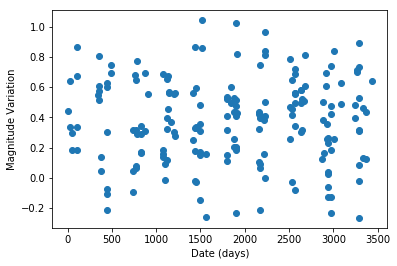

In [137]:
perfex = np.linspace(0, 3500, 3501)
#perfect = [0.1*np.sin((2*np.pi*(frange*0.01))*(x)) for x in perfex]

plt.plot(date, amplitude, 'o')
#plt.plot(perfex, perfect)
plt.ylabel('Magnitude Variation')
plt.xlabel('Date (days)')
#plt.xlim([2200, 2300])
plt.show()

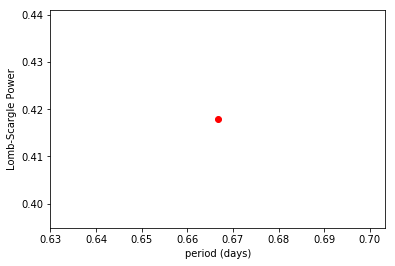

In [138]:
plt.plot(actualperiod, measuredpower)
plt.plot(measuredperiod, measuredpower, 'ro')
plt.xlabel('period (days)')
plt.ylabel('Lomb-Scargle Power')
plt.show()

In [45]:
def over9000(frequencyRange,objectmag,loopNo,modulationAmplitude=0.1,background=40,Nquist=5000,numsteps=20000): # frequency range and object mag in list
    global maxpower, powerperiod
#     powerperiod = []
    maxpower = [] # reset

    for frange in range(0, len(frequencyRange)):    
        allobsy, uobsy, gobsy, robsy, iobsy, zobsy, yobsy = [], [], [], [], [], [], [] #reset
        
        y = [allobsy, uobsy, gobsy, robsy, iobsy, zobsy, yobsy] # for looping only
        for z in range(1, len(y)):
            y[z] = averageFlux(obs[z], frequencyRange[frange], 30)  # amplitde calculation for observations, anf frequency range
        for z in range(1, len(y)):
            y[z] = [modulationAmplitude * t for t in y[z]]
        
        for z in range(1,len(y)):    # loops over number filters
            for G in range(0, len(y[z])): # loops over number of obs
                flareMinute = int((obs[z][G]*24*60)%(1024))
                y[z][G] = y[z][G] + flareMag[flareMinute]
                
        for z in range(3,4):#(1, len(y)):
            date = [x - obs[z][0] for x in obs[z]]
            date = date * u.day
            amplitude = [t+random.gauss(0,magUncertainy(zeroPoints[z],objectmag[z],30,background,FWHMeff[z])) for t in y[z]] # scale amplitude and add poisson noise
            mag = [t + objectmag[z] for t in amplitude]
            error = [sigSys+magUncertainy(zeroPoints[z],objectmag[z],30,background,FWHMeff[z])+0.2]*len(mag) 
            
        for loop in range(0,loopNo):
            random.shuffle(date)
            model = LombScargleFast().fit(date, mag, error)
            periods, power = model.periodogram_auto(nyquist_factor=Nquist)
            model.optimizer.period_range=(0.01, 10)
            maxpower.append(power.max())
#             LSperiod = model.best_period
#             powerperiod.append(LSperiod)
            
    

Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


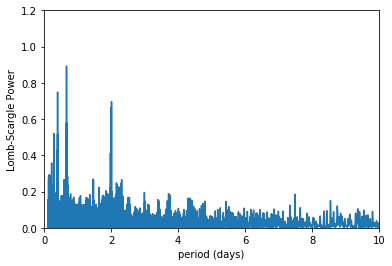

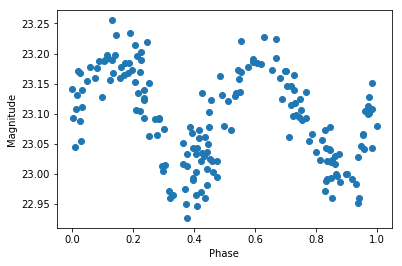

('actualperiod', 0.6666666666666666, 'measured period', 0.6666633565626654) 150
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  0.01 to 10
 - Computing periods at 1717106 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps
Finding optimal frequency:
 - Estimated peak width = 0.00183
 - Using 5 steps per peak; omega_step = 0.000366
 - User-specified period range:  

KeyboardInterrupt: 

In [65]:
findObservations([(630,)])
#addsecondExposure()
averageFlux(obs[0], 1, 30)
flaring(-1, 10024, amplitude=0.1)
lombScargle([150],([23]*7),Nquist=300)
over9000([150],([23]*7),10000,Nquist=300)

In [84]:
print(len(flareMag))

10024


In [86]:
flaring(-1, 10024, amplitude=0.1)

[(0.096285231999796494-0.00066698571658670581j),
 (0.11831257029297321-0.010627633050193638j),
 (0.10508115723664264-0.0064927519764959906j),
 (0.082643993153360018-0.037937965411491241j),
 (0.075199127877770292+0.0044128204417523669j),
 (0.0800090292053523+0.002502584022320363j),
 (0.049252362078755905+0.029628019422489073j),
 (0.075410209288261476+0.015754392209121133j),
 (0.11907960243878202+0.050738341315133176j),
 (0.12797254145618814+0.027513551144934575j),
 (0.14843055749134065+0.0019549167747754501j),
 (0.086667905599481898-0.022844103121514137j),
 (0.11156392841605192-0.011771040921905337j),
 (0.10349126947354806+0.012291950357653198j),
 (0.098670270353832232-0.040126989835044598j),
 (0.075842663747040642-0.0006915798825803776j),
 (0.074919631634156214+0.011327118160440502j),
 (0.070392519656473446+0.029857103692545933j),
 (0.10732654844444714+0.028593208450381536j),
 (0.10241191777771051+0.015514242296077688j),
 (0.095255991781771299+0.018055649574551687j),
 (0.13761213222323

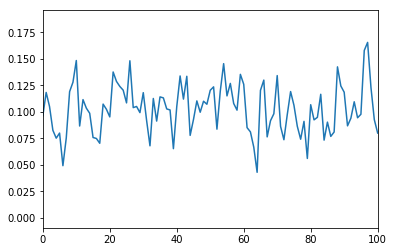

In [88]:
plt.plot(minutes,flareMag)
plt.xlim(0,100)
plt.show()

In [89]:
print(minutes[-1])

10024.0


In [90]:
10024/(60.*24.)

6.961111111111111

In [92]:
a = averageFlux(minutes, 150, 30)
b = flaring(-1, 10024, amplitude=0.1)

#random.gauss(0,magUncertainy(zeroPoints[z],objectmag[z],30,background,FWHMeff[z]))
#plt.plot
print(len(a),len(b))

(10024, 10024)


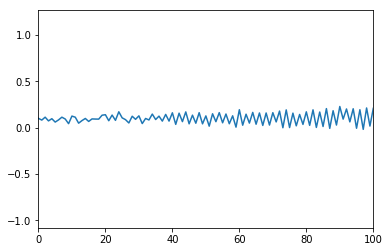

In [96]:
c = [0]*len(a)
for w in range(0,len(a)):
    c[w] = a[w] + b[w]
plt.plot(minutes,c)
plt.xlim(0,100)
plt.show()

In [103]:
minutes

[0.0,
 1.0000997705277861,
 2.0001995410555722,
 3.0002993115833583,
 4.0003990821111444,
 5.0004988526389305,
 6.0005986231667165,
 7.0006983936945026,
 8.0007981642222887,
 9.0008979347500748,
 10.000997705277861,
 11.001097475805647,
 12.001197246333433,
 13.001297016861219,
 14.001396787389005,
 15.001496557916791,
 16.001596328444577,
 17.001696098972364,
 18.00179586950015,
 19.001895640027936,
 20.001995410555722,
 21.002095181083508,
 22.002194951611294,
 23.00229472213908,
 24.002394492666866,
 25.002494263194652,
 26.002594033722438,
 27.002693804250224,
 28.002793574778011,
 29.002893345305797,
 30.002993115833583,
 31.003092886361369,
 32.003192656889155,
 33.003292427416937,
 34.003392197944727,
 35.003491968472517,
 36.003591739000299,
 37.003691509528082,
 38.003791280055871,
 39.003891050583661,
 40.003990821111444,
 41.004090591639226,
 42.004190362167016,
 43.004290132694805,
 44.004389903222588,
 45.004489673750371,
 46.00458944427816,
 47.00468921480595,
 48.0047889